In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE
from src.agents.RAGAgent import embed_text

In [3]:
import psutil
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"Total RAM: {ram_gb:.2f} GB")


Total RAM: 15.42 GB


# RAG

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
def rag_similarity(context, pos_query, neg_query):
    model = 'ollama/nomic-embed-text'
    z_context = embed_text(context, model)
    z_pos_query = embed_text(pos_query, model)
    z_neg_query = embed_text(neg_query, model)

    return np.dot(z_context, z_pos_query), np.dot(z_context, z_neg_query)
    #print(f'RAG similarity: {np.dot(z1_norm, z2_norm)}')

# SAE

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
sae_base_model_name = "EleutherAI/pythia-70m-deduped"
sae_release = "ctigges/pythia-70m-deduped__res-sm_processed"
sae_id      = "4-res-sm"
hook_name   = "blocks.4.hook_resid_post"

In [7]:
sae_base_model_name = "gemma-2b-it"
sae_release = "gemma-2b-it-res-jb"
sae_id = "blocks.12.hook_resid_post"
hook_name = "blocks.12.hook_resid_post" 

In [8]:
sae_base_model = HookedTransformer.from_pretrained_no_processing(
    sae_base_model_name,
    device=device,
    dtype=torch.float16,   # float32 is safest on CPU
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards: 100%|██████████| 2/2 [00:37<00:00, 18.83s/it]


Loaded pretrained model gemma-2b-it into HookedTransformer


In [9]:
sae, sae_cfg, sparsity = SAE.from_pretrained(
    release=sae_release,
    sae_id=sae_id,
    device=device,
)
sae.eval()

/tmp/ipykernel_46706/1603754695.py:1: DeprecationWarning: Unpacking SAE objects is deprecated. SAE.from_pretrained() now returns only the SAE object. Use SAE.from_pretrained_with_cfg_and_sparsity() to get the config dict and sparsity as well.
  sae, sae_cfg, sparsity = SAE.from_pretrained(


StandardSAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [10]:
def sae_encode_text(
    model, 
    sae, 
    text, 
    hook_name, 
    prepend_bos=True, 
    method="mean",   # "mean", "max", or "topk"
    k=3
):
    with torch.no_grad():
        tokens = model.to_tokens(text, prepend_bos=prepend_bos)
        _, cache = model.run_with_cache(tokens, names_filter=[hook_name])
        acts = cache[hook_name]              # [batch, seq, d_model]
        acts_no_bos = acts[:, 1:, :]         # [batch, seq-1, d_model]
        feature_acts = sae.encode(acts_no_bos)  # [batch, seq-1, n_features]

        # ------- Aggregation methods -------
        if method == "mean":
            z = feature_acts.mean(dim=1)     # [B, F]

        elif method == "max":
            z = feature_acts.max(dim=1).values  # [B, F]

        elif method == "topk":
            seq_len = feature_acts.shape[1]
            k_eff = min(k, seq_len)
            topk_vals, _ = torch.topk(feature_acts, k=k_eff, dim=1)
            z = topk_vals.mean(dim=1)        # [B, F]

        else:
            raise ValueError(f"Unknown method '{method}', choose from 'mean', 'max', 'topk'.")

        # Final vector
        z = z.squeeze(0).cpu().numpy()
        return z / np.linalg.norm(z)

In [47]:
def tanimoto_similarity(z1, z2):
    dot = np.dot(z1, z2)
    denom = np.dot(z1, z1) + np.dot(z2, z2) - dot
    return dot / denom if denom != 0 else 0.0

def jaccard_similarity(z1, z2):
    f1 = set(np.nonzero(z1)[0])
    f2 = set(np.nonzero(z2)[0])
    return len(f1 & f2) / len(f1 | f2)

def sae_similarity(context, pos_query, neg_query, method="topk", k=3):
    z_context = sae_encode_text(sae_base_model, sae, context, hook_name, method=method, k=k)
    z_pos_query = sae_encode_text(sae_base_model, sae, pos_query, hook_name, method=method, k=k)
    z_neg_query = sae_encode_text(sae_base_model, sae, neg_query, hook_name, method=method, k=k)
    return np.dot(z_context, z_pos_query), np.dot(z_context, z_neg_query)
    #return tanimoto_similarity(z_context, z_pos_query), tanimoto_similarity(z_context, z_neg_query)
    #return jaccard_similarity(z_context, z_pos_query), jaccard_similarity(z_context, z_neg_query)


# SAE vs RAG

In [12]:
def compare(context, pos_query, neg_query):
    return rag_similarity(context, pos_query, neg_query), sae_similarity(context, pos_query, neg_query)

In [13]:
examples = [
    # Example 1
    dict(
        context=(
            "User: Which one would you say is the best for a romantic dinner?\n"
            "Assistant: I would recommend Roscioli. It has a cozy and intimate atmosphere "
            "with soft lighting and excellent service."
        ),
        pos_query="Can you remind me of the romantic restaurant in Rome you recommended for dinner?",
        neg_query="Can you remind me which museum in Rome you said had the best collection of ancient sculptures?",
    ),

    # Example 2
    dict(
        context=(
            "User: I want a compact camera for street photography, something small but with great image quality. "
            "Any suggestions?\n"
            "Assistant: You might really like the Ricoh GR III. It’s very pocketable and has an excellent "
            "28mm-equivalent lens that’s great for street shots."
        ),
        pos_query="What was the small street photography camera you suggested, the one with the 28mm lens?",
        neg_query="What was the tripod you recommended for long-exposure night photography?",
    ),

    # Example 3
    dict(
        context=(
            "User: My API is slowing down under load. Could it be the Docker configuration?\n"
            "Assistant: It’s possible. I’d start by checking the CPU and memory limits on the container "
            "and see if you’re hitting them during peak traffic."
        ),
        pos_query="What did you say I should look at in my Docker setup to understand why the API slows down?",
        neg_query="What did you say I should look at in my Postgres configuration to reduce slow queries?",
    ),

    # Example 4
    dict(
        context=(
            "User: I’m trying to choose between airlines for a long-haul flight to Tokyo. Any preference?\n"
            "Assistant: If you can, go with ANA. Their economy seats are more comfortable and the service "
            "is consistently excellent."
        ),
        pos_query="Which airline did you say was better for my long flight to Tokyo?",
        neg_query="Which website did you say was best for finding cheap hotel deals in Tokyo?",
    ),

    # Example 5
    dict(
        context=(
            "User: I have an exam in statistical mechanics next month and I’m overwhelmed. "
            "How should I structure my study time?\n"
            "Assistant: Focus first on the partition function and the main ensembles. Then spend time on typical "
            "problems with phase transitions and critical exponents, and leave the more exotic topics for last."
        ),
        pos_query="What did you tell me to prioritize when studying for my statistical mechanics exam?",
        neg_query="What did you tell me to prioritize when preparing my job interview presentation?",
    ),

    # Example 6
    dict(
        context=(
            "User: I need a laptop for machine learning experiments. Any particular specs I should aim for?\n"
            "Assistant: Try to get at least 32 GB of RAM and an NVIDIA GPU with at least 8 GB of VRAM. "
            "That will make training small to medium models much smoother."
        ),
        pos_query="Can you remind me what specs you recommended for a laptop to run my ML experiments?",
        neg_query="Can you remind me what specs you recommended for a monitor for photo editing?",
    ),

    # Example 7
    dict(
        context=(
            "User: I’m visiting Barcelona for a few days and want a nice day hike nearby. Any suggestions?\n"
            "Assistant: You could hike in Montserrat. It’s about an hour from the city by train and has beautiful "
            "mountain views and well-marked trails."
        ),
        pos_query="What was the hiking spot near Barcelona you mentioned that I can reach by train?",
        neg_query="What was the beach town near Barcelona you mentioned that’s good for a day of swimming?",
    ),

    # Example 8
    dict(
        context=(
            "User: I want a sci-fi novel that’s thoughtful but still fun to read. Any ideas?\n"
            "Assistant: You might enjoy \"The Three-Body Problem.\" It mixes hard science with a very engaging story."
        ),
        pos_query="Which sci-fi book did you recommend that combines hard science with an engaging story?",
        neg_query="Which non-fiction book did you recommend for learning basic investing principles?",
    ),
    {
    "context": (
        "User: I'm finally replacing my old laptop. Do you think 16GB of RAM is enough for light coding?\n"
        "Assistant: For light coding it's fine, but if you plan to do ML experiments or heavy multitasking, "
        "I'd recommend going for 32GB instead."
    ),
    "pos_query": "What was the RAM amount you recommended for heavier ML coding workloads?",
    "neg_query": "What was the phone model you said had the best battery life for traveling?"
    },
    {
        "context": (
            "User: I'm planning a trip to Florence. Is there a museum I absolutely shouldn't miss?\n"
            "Assistant: Definitely visit the Uffizi Gallery. It's one of the most important art museums in the world."
        ),
        "pos_query": "What was the museum in Florence you told me I shouldn't miss?",
        "neg_query": "Which restaurant in Florence did you say had the best bistecca alla fiorentina?"
    },

    {
        "context": (
            "User: I'm choosing a film camera for trying analog photography. Any recommendation?\n"
            "Assistant: The Nikon FE is a great starting point. Reliable, sturdy, and easy to use."
        ),
        "pos_query": "Which beginner film camera did you recommend to me?",
        "neg_query": "What digital camera did you say was best for recording 4K video?"
    },

    {
        "context": (
            "User: My sourdough bread keeps coming out too dense. What should I fix?\n"
            "Assistant: Try increasing the hydration slightly and give the dough a longer bulk fermentation."
        ),
        "pos_query": "What did you say I should adjust in my sourdough recipe to avoid dense loaves?",
        "neg_query": "What did you say I should adjust in my lasagna recipe to make the sauce thicker?"
    },

    {
        "context": (
            "User: I'm thinking of learning a second programming language after Python. Suggestions?\n"
            "Assistant: Go with Rust. It forces good habits and teaches you a lot about memory safety and performance."
        ),
        "pos_query": "Which programming language did you recommend I learn after Python?",
        "neg_query": "Which photo editing software did you recommend for color grading RAW images?"
    },

    {
        "context": (
            "User: I want something philosophical but easy to read. Any book recommendations?\n"
            "Assistant: You might like 'The Stranger' by Albert Camus. It's short but very thought-provoking."
        ),
        "pos_query": "Which philosophical novel did you recommend that was short and thought-provoking?",
        "neg_query": "Which fantasy novel did you recommend that had dragons and magic?"
    },

    {
        "context": (
            "User: I'm trying intermittent fasting for the first time. Any tips for beginners?\n"
            "Assistant: Start with a 14:10 schedule and gradually increase the fasting window if you feel comfortable."
        ),
        "pos_query": "What fasting schedule did you say was good for beginners?",
        "neg_query": "What running schedule did you say was good for preparing a marathon?"
    },

    {
        "context": (
            "User: My code is running much slower after I moved to Windows from Linux. Any ideas?\n"
            "Assistant: Check whether Windows Defender is scanning your Python files. That often slows down execution."
        ),
        "pos_query": "What did you say might be slowing down my Python code on Windows?",
        "neg_query": "What did you say might be causing my internet to disconnect randomly?"
    },

    {
        "context": (
            "User: I'm decorating my apartment and want a minimalist look. Any advice?\n"
            "Assistant: Stick to neutral colors and reduce visible clutter. Furniture with clean lines works best."
        ),
        "pos_query": "What kind of design recommendations did you give me for a minimalist apartment?",
        "neg_query": "What kind of exercise recommendations did you give me for building muscle?"
    },

    {
        "context": (
            "User: I'm learning guitar but my fingers hurt a lot. Is that normal?\n"
            "Assistant: Yes, totally normal. You'll develop calluses after a few weeks and the pain will decrease."
        ),
        "pos_query": "What did you say would eventually stop hurting when practicing guitar?",
        "neg_query": "What did you say would eventually improve if I keep practicing my coding skills?"
    }

]


In [14]:
def test_method(backend, method=None, k=None):
    """
    backend: "rag" or "sae"
    method, k: passed through to sae_similarity when backend == "sae"
    """
    related = []
    unrelated = []

    for ex in examples:
        if backend == "rag":
            pos, neg = rag_similarity(
                ex["context"],
                ex["pos_query"],
                ex["neg_query"],
            )
        elif backend == "sae":
            pos, neg = sae_similarity(
                ex["context"],
                ex["pos_query"],
                ex["neg_query"],
                method,
                k,
            )
        else:
            raise ValueError(f"Unknown backend: {backend}. Use 'rag' or 'sae'.")

        related.append(pos)
        unrelated.append(neg)

    # Convert to numpy arrays
    related = np.array(related)
    unrelated = np.array(unrelated)

    # Helper to compute propagated error of the separation
    def compute_sep_error(std_rel, std_unrel, n):
        se_rel = std_rel / np.sqrt(n)
        se_unrel = std_unrel / np.sqrt(n)
        return float(np.sqrt(se_rel**2 + se_unrel**2))

    std_rel = float(related.std())
    std_unrel = float(unrelated.std())
    n = len(related)

    stats = {
        "backend": backend,  # "rag" or "sae"
        "mean_related": float(related.mean()),
        "std_related": std_rel,
        "mean_unrelated": float(unrelated.mean()),
        "std_unrelated": std_unrel,
        "separation": float(related.mean() - unrelated.mean()),
        "separation_error": compute_sep_error(std_rel, std_unrel, n),
        "n": n,
    }

    return stats


In [ ]:
def plot_separation(stats_list, labels):
    separations = [s["separation"] for s in stats_list]
    errors = [s["separation_error"] for s in stats_list]

    # For debugging if needed
    # print("separations:", separations)
    # print("errors:", errors)

    # Build a small DataFrame so seaborn is happy
    df = pd.DataFrame({
        "method": labels,
        "separation": separations,
        "error": errors,
    })

    plt.figure(figsize=(6, 4))

    # Draw bars with seaborn (no built-in yerr here, so ci=None)
    ax = sns.barplot(
        data=df,
        x="method",
        y="separation",
        ci=None,          # don't let seaborn compute its own error bars
    )

    # Add our own error bars with matplotlib
    x_positions = np.arange(len(df))
    ax.errorbar(
        x=x_positions,
        y=df["separation"],
        yerr=df["error"],
        fmt="none",
        capsize=5,
        color="black",
        linewidth=1.5,
    )

    ax.set_ylabel("Separation")
    ax.set_xlabel("")


    plt.tight_layout()
    plt.show()

In [55]:
rag_stats = test_method('rag')
sae_mean_stats = test_method('sae', method="mean")
sae_max_stats = test_method('sae', method="max")
sae_top3_stats = test_method('sae', method="topk", k=3)
sae_top10_stats = test_method('sae', method="mean", k=10)

/tmp/ipykernel_46706/14139244.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


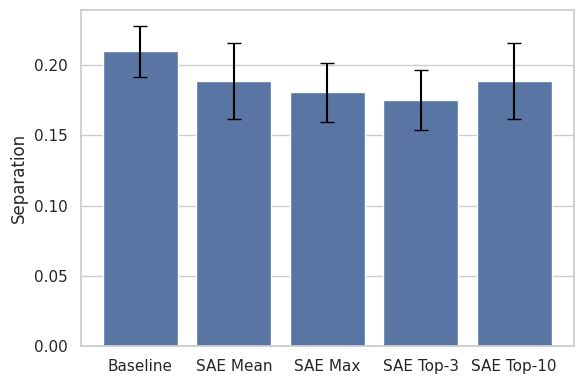

In [56]:
plot_separation([rag_stats, sae_mean_stats, sae_max_stats, sae_top3_stats, sae_top10_stats], ['Baseline', 'SAE Mean', 'SAE Max', 'SAE Top-3', 'SAE Top-10'])

In [21]:
test_method("max")

========== RAG SIMILARITY ==========
Mean related similarity   : 0.7980174615796013 0.0447352891689297
Mean unrelated similarity : 0.5882399145760032 0.06277481162354855
Separation (related - unrelated): 0.20977754700359807

========== SAE SIMILARITY ==========
Mean related similarity   : 0.3673504 0.060817957
Mean unrelated similarity : 0.18679272 0.06621986
Separation (related - unrelated): 0.18055768

Counts -> related: 18 unrelated: 18


In [22]:
test_method("topk", k=3)

========== RAG SIMILARITY ==========
Mean related similarity   : 0.7980174615796013 0.0447352891689297
Mean unrelated similarity : 0.5882399145760032 0.06277481162354855
Separation (related - unrelated): 0.20977754700359807

========== SAE SIMILARITY ==========
Mean related similarity   : 0.43167365 0.06786506
Mean unrelated similarity : 0.2562137 0.059962727
Separation (related - unrelated): 0.17545995

Counts -> related: 18 unrelated: 18


In [23]:
test_method("topk", k=5)

========== RAG SIMILARITY ==========
Mean related similarity   : 0.7980174615796013 0.0447352891689297
Mean unrelated similarity : 0.5882399145760032 0.06277481162354855
Separation (related - unrelated): 0.20977754700359807

========== SAE SIMILARITY ==========
Mean related similarity   : 0.4598261 0.06515279
Mean unrelated similarity : 0.29110044 0.061601207
Separation (related - unrelated): 0.16872567

Counts -> related: 18 unrelated: 18


In [24]:
test_method("topk", k=10)

========== RAG SIMILARITY ==========
Mean related similarity   : 0.7980174615796013 0.0447352891689297
Mean unrelated similarity : 0.5882399145760032 0.06277481162354855
Separation (related - unrelated): 0.20977754700359807

========== SAE SIMILARITY ==========
Mean related similarity   : 0.47961175 0.07108512
Mean unrelated similarity : 0.30776542 0.068244085
Separation (related - unrelated): 0.17184633

Counts -> related: 18 unrelated: 18


In [26]:
import numpy as np
from collections import defaultdict

# 1) Run RAG + SAE on all examples and store results
results = []
for ex in examples:
    context = ex["context"]
    pos_q = ex["pos_query"]
    neg_q = ex["neg_query"]

    rag_pos, rag_neg = rag_similarity(context, pos_q, neg_q)
    sae_pos, sae_neg = sae_similarity(context, pos_q, neg_q, 'max')

    results.append({
        "context": context,
        "pos_query": pos_q,
        "neg_query": neg_q,
        "rag_pos": rag_pos,
        "rag_neg": rag_neg,
        "sae_pos": sae_pos,
        "sae_neg": sae_neg,
    })

# 2) Group by context (conversation)
groups = defaultdict(list)
for r in results:
    groups[r["context"]].append(r)

# 3) For each group, compute separation for RAG and SAE
group_summaries = []

for context, group in groups.items():
    rag_pos_vals = [g["rag_pos"] for g in group]
    rag_neg_vals = [g["rag_neg"] for g in group]
    sae_pos_vals = [g["sae_pos"] for g in group]
    sae_neg_vals = [g["sae_neg"] for g in group]

    # Need at least one related and one unrelated to define a separation
    if not rag_pos_vals or not rag_neg_vals or not sae_pos_vals or not sae_neg_vals:
        continue

    rag_sep = np.mean(rag_pos_vals) - np.mean(rag_neg_vals)
    sae_sep = np.mean(sae_pos_vals) - np.mean(sae_neg_vals)

    group_summaries.append({
        "context": context,
        "group": group,
        "rag_sep": rag_sep,
        "sae_sep": sae_sep,
        "delta": sae_sep - rag_sep,  # how much SAE beats RAG (if positive)
    })

# 4) Filter to where SAE outperforms RAG and sort by how much
better_for_sae = [g for g in group_summaries if g["sae_sep"] > g["rag_sep"]]
better_for_sae.sort(key=lambda g: g["delta"], reverse=True)

# 5) Pretty-print the cases where SAE > RAG
for g in better_for_sae:
    print("=" * 80)
    print("Context (conversation):")
    print(g["context"])
    print()
    print(f"RAG separation: {g['rag_sep']:.4f}")
    print(f"SAE separation: {g['sae_sep']:.4f}")
    print(f"SAE - RAG      : {g['delta']:.4f}")

    print("\nRelated (pos_query) and sims:")
    for r in g["group"]:
        print(f"  [RAG={r['rag_pos']:.4f}, SAE={r['sae_pos']:.4f}]  {r['pos_query']}")

    print("\nUnrelated (neg_query) and sims:")
    for r in g["group"]:
        print(f"  [RAG={r['rag_neg']:.4f}, SAE={r['sae_neg']:.4f}]  {r['neg_query']}")
    print()


Context (conversation):
User: I want a sci-fi novel that’s thoughtful but still fun to read. Any ideas?
Assistant: You might enjoy "The Three-Body Problem." It mixes hard science with a very engaging story.

RAG separation: 0.1755
SAE separation: 0.3364
SAE - RAG      : 0.1609

Related (pos_query) and sims:
  [RAG=0.7535, SAE=0.4608]  Which sci-fi book did you recommend that combines hard science with an engaging story?

Unrelated (neg_query) and sims:
  [RAG=0.5780, SAE=0.1244]  Which non-fiction book did you recommend for learning basic investing principles?

Context (conversation):
User: I want a compact camera for street photography, something small but with great image quality. Any suggestions?
Assistant: You might really like the Ricoh GR III. It’s very pocketable and has an excellent 28mm-equivalent lens that’s great for street shots.

RAG separation: 0.1460
SAE separation: 0.2407
SAE - RAG      : 0.0947

Related (pos_query) and sims:
  [RAG=0.7889, SAE=0.4435]  What was the sma

In [30]:
compare(
    "User: I yelled at my sister yesterday and now she won’t talk to me.\n"
    "Assistant: That sounds painful. When something can’t be taken back, the focus becomes repairing trust.\n"
    "User: I wish I could undo it.",
    "How do I deal with a mistake that I can’t take back?"
)

In [13]:
compare("He planted the seed in spring and waited months for anything to happen.",
        "She submitted her PhD application and knew the results would arrive much later.")

RAG similarity: 0.5280847636696077
SAE similarity: 0.15224242210388184


In [14]:
compare("Once the glass shattered, there was no way back.",
        "When she sent the angry email, the relationship changed permanently.")

RAG similarity: 0.4709199426788174


KeyboardInterrupt: 

In [ ]:
compare("He invested everything for a chance at a breakthrough.",
        "She stepped onto the stage knowing the risk was worth the opportunity.")

RAG similarity: 0.5718832471264863
SAE similarity: 0.534549355506897


In [10]:
compare('She closed the window because the cold wind was coming in.',
        'She shut the window to keep the chilly breeze out.')

RAG similarity: 0.9285133402558516
SAE similarity: 0.5873538255691528


In [22]:
compare('He hurried to catch the last train before midnight.',
        'He rushed to board the final train that left just before twelve.')

RAG similarity: 0.9019049688465273
SAE similarity: 0.6499947905540466


In [23]:
compare('The book was so captivating that she finished it in one night.',
        'She read the whole novel in a single evening because it was irresistible.')

RAG similarity: 0.8380246617842546
SAE similarity: 0.6573800444602966


In [24]:
compare('The dog barked loudly at the mail carrier.',
        'The dog made a racket when the postal worker approached.')

RAG similarity: 0.8239608511256304
SAE similarity: 0.589231014251709


In [25]:
compare('The cat slept on the warm radiator.',
        'Quantum computers require extremely low temperatures to operate.')

RAG similarity: 0.5298888996725823
SAE similarity: 0.5248370170593262


In [26]:
compare('The nebula glowed faintly as the telescope adjusted its focus.',
        'I forgot to buy onions for the pasta sauce.')

RAG similarity: 0.34518207932378536
SAE similarity: 0.383361279964447


In [27]:
compare('The café down the street started selling homemade lemonade.',
        'Saturn’s rings are mostly composed of ice particles.')

RAG similarity: 0.31755464184461646
SAE similarity: 0.31813913583755493


In [28]:
compare('My shoes got soaked when it started raining unexpectedly.',
        'The server must be restarted after applying the new kernel patch.')

RAG similarity: 0.3717168859381351
SAE similarity: 0.43883946537971497


In [29]:
compare('What if my child just refuses to take responsibility for their actions? How do I get them to understand the importance of being accountable?',
        'How many days did I spend on camping trips in the United States this year?')

RAG similarity: 0.3164769270993337
SAE similarity: 0.33727002143859863


Aún cuando están relacionados conceptualmente y no semánticamente, RAG es mejor que SAE

In [30]:
compare('If you pack too many tools into a small backpack, something essential will always get left behind.',
        'A neural network with fixed width can’t memorize new patterns without forgetting some of the old ones.')

RAG similarity: 0.4902988564590743
SAE similarity: 0.3685685396194458


In [31]:
compare('A single spark landing in dry grass can turn into a wildfire by nightfall.',
        'One unstable nucleotide in a cell can initiate a cascade of replication errors.')

RAG similarity: 0.540741589430252
SAE similarity: 0.47643065452575684


In [32]:
compare('Watering a plant twice doesn’t make it grow twice as fast.',
        'Doubling your training epochs rarely doubles your model’s accuracy.')

RAG similarity: 0.5917122431442312
SAE similarity: 0.3543633222579956
